In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob, os
import sys

In [19]:
prep_deals = pd.read_pickle('./data/marketreplay/input/all_features_df.pkl')
prep_deals.columns

Index(['Id', 'Moment', 'Client', 'Pair', 'BookSide', 'Source', 'Tier', 'Tenor',
       'TurnoverCloseRisk', 'TurnoverOpenRisk', 'TurnoverToMarket',
       'UnrealizedPL', 'MidToMid', 'HedgingCost', 'HoldPositionTime',
       'BookPositionReferenceCurrency', 'PublicMidPrice', 'BaseQty',
       'ReferenceClientPrice', 'TradePositionReferenceCurrency', 'TernQty',
       'ReferenceTraderPrice', 'Type', 'mid0', 'prev_r_mean', 'prev_r_val',
       'next_2', 'next_last', 'Hour', 'DayOfWeek', 'Month', 'Expencies',
       'clp_mid_diff', 'clp_mid_diff_qty'],
      dtype='object')

In [20]:
prep_deals['next_2_clp_diff'] = 0.0
prep_deals.loc[prep_deals.BookSide == 'BUY','next_2_clp_diff'] = \
prep_deals.loc[prep_deals.BookSide == 'BUY','next_2'] / \
prep_deals.loc[prep_deals.BookSide == 'BUY','ReferenceClientPrice'] > 1.0001

prep_deals.loc[prep_deals.BookSide == 'SELL','next_2_clp_diff'] = \
prep_deals.loc[prep_deals.BookSide == 'SELL','next_2'] / \
prep_deals.loc[prep_deals.BookSide == 'SELL','ReferenceClientPrice'] < 0.9999

In [21]:
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
prep_deals['Client_int'] = le.fit_transform(prep_deals['Client'])


In [22]:
train_buy_X = prep_deals.loc[(prep_deals.BookSide == 'BUY') & (prep_deals.Month == 8), 
                          ['BookPositionReferenceCurrency', 'BaseQty', 'Hour', 'DayOfWeek','Client_int',
                           'prev_r_mean', 'prev_r_val']]
train_buy_Y = prep_deals.loc[(prep_deals.BookSide == 'BUY') & (prep_deals.Month == 8), 
                          ['next_2_clp_diff']]

test_buy_X = prep_deals.loc[(prep_deals.BookSide == 'BUY') & (prep_deals.Month == 9), 
                          ['BookPositionReferenceCurrency', 'BaseQty', 'Hour', 'DayOfWeek','Client_int',
                           'prev_r_mean', 'prev_r_val']]
test_buy_Y = prep_deals.loc[(prep_deals.BookSide == 'BUY') & (prep_deals.Month == 9), 
                          ['next_2_clp_diff']]


train_sell_X = prep_deals.loc[(prep_deals.BookSide == 'SELL') & (prep_deals.Month == 8), 
                          ['BookPositionReferenceCurrency', 'BaseQty', 'Hour', 'DayOfWeek','Client_int',
                           'prev_r_mean', 'prev_r_val']]
train_sell_Y = prep_deals.loc[(prep_deals.BookSide == 'SELL') & (prep_deals.Month == 8), 
                          ['next_2_clp_diff']]

test_sell_X = prep_deals.loc[(prep_deals.BookSide == 'SELL') & (prep_deals.Month == 9), 
                          ['BookPositionReferenceCurrency', 'BaseQty', 'Hour', 'DayOfWeek','Client_int',
                           'prev_r_mean', 'prev_r_val']]
test_sell_Y = prep_deals.loc[(prep_deals.BookSide == 'SELL') & (prep_deals.Month == 9), 
                          ['next_2_clp_diff']]

In [23]:
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier
from sklearn import metrics

train_data = lgb.Dataset(train_buy_X, label=train_buy_Y.astype(int), 
                         feature_name=['BookPositionReferenceCurrency', 'BaseQty', 
                                       'Hour', 'DayOfWeek',
                                       'Client_int', 'prev_r_mean', 'prev_r_val'], 
                         categorical_feature=['Client_int','Hour', 'DayOfWeek'])

validation_data = lgb.Dataset(test_buy_X, label=test_buy_Y.astype(int), 
                         feature_name=['BookPositionReferenceCurrency', 'BaseQty', 
                                       'Hour', 'DayOfWeek',
                                       'Client_int', 'prev_r_mean', 'prev_r_val'], 
                         categorical_feature=['Client_int','Hour', 'DayOfWeek'])


param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 25
bst_buy = lgb.train(param, train_data, num_round, valid_sets=[validation_data])


[LightGBM] [Info] Number of positive: 738, number of negative: 10999
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 11737, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062878 -> initscore=-2.701616
[LightGBM] [Info] Start training from score -2.701616
[1]	valid_0's auc: 0.64783
[2]	valid_0's auc: 0.660539
[3]	valid_0's auc: 0.66766
[4]	valid_0's auc: 0.672011
[5]	valid_0's auc: 0.674541
[6]	valid_0's auc: 0.676279
[7]	valid_0's auc: 0.676025
[8]	valid_0's auc: 0.676589
[9]	valid_0's auc: 0.677123
[10]	valid_0's auc: 0.674791
[11]	valid_0's auc: 0.676954
[12]	valid_0's auc: 0.67689
[13]	valid_0's auc: 0.676448
[14]	valid_0's auc: 0.678033
[15]	valid_0's auc: 0.677885
[16]	valid_0's auc: 0.678743
[17]	valid_0's auc: 0.678711
[18]	valid_0's auc: 0.678

/Users/a16643222/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/a16643222/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/a16643222/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [24]:
train_data = lgb.Dataset(train_sell_X, label=train_sell_Y.astype(int), 
                         feature_name=['BookPositionReferenceCurrency', 'BaseQty', 
                                       'Hour', 'DayOfWeek',
                                       'Client_int', 'prev_r_mean', 'prev_r_val'], 
                         categorical_feature=['Client_int','Hour', 'DayOfWeek'])

validation_data = lgb.Dataset(test_sell_X, label=test_sell_Y.astype(int), 
                         feature_name=['BookPositionReferenceCurrency', 'BaseQty', 
                                       'Hour', 'DayOfWeek',
                                       'Client_int', 'prev_r_mean', 'prev_r_val'], 
                         categorical_feature=['Client_int','Hour', 'DayOfWeek'])


param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 25
bst_sell = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

[LightGBM] [Info] Number of positive: 1212, number of negative: 11594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 12806, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.094643 -> initscore=-2.258216
[LightGBM] [Info] Start training from score -2.258216
[1]	valid_0's auc: 0.655798
[2]	valid_0's auc: 0.66767
[3]	valid_0's auc: 0.676151
[4]	valid_0's auc: 0.682617
[5]	valid_0's auc: 0.681708
[6]	valid_0's auc: 0.682395
[7]	valid_0's auc: 0.684787
[8]	valid_0's auc: 0.684583
[9]	valid_0's auc: 0.684702
[10]	valid_0's auc: 0.685538
[11]	valid_0's auc: 0.686681
[12]	valid_0's auc: 0.686808
[13]	valid_0's auc: 0.685901
[14]	valid_0's auc: 0.686037
[15]	valid_0's auc: 0.683285
[16]	valid_0's auc: 0.684206
[17]	valid_0's auc: 0.683692
[18]	valid_0's auc: 0.

In [25]:
prep_deals['is_accept_buy_reject'] = -1
prep_deals.loc[(prep_deals.BookSide == 'BUY') & (prep_deals.Month == 9), 'is_accept_buy_reject'] = \
bst_buy.predict(prep_deals.loc[(prep_deals.BookSide == 'BUY') & (prep_deals.Month == 9), 
                          ['BookPositionReferenceCurrency', 'BaseQty', 'Hour', 'DayOfWeek','Client_int',
                           'prev_r_mean', 'prev_r_val']]) 

In [26]:
prep_deals['is_accept_sell_reject'] = -1
prep_deals.loc[(prep_deals.BookSide == 'SELL') & (prep_deals.Month == 9), 'is_accept_sell_reject'] = \
bst_sell.predict(prep_deals.loc[(prep_deals.BookSide == 'SELL') & (prep_deals.Month == 9), 
                          ['BookPositionReferenceCurrency', 'BaseQty', 'Hour', 'DayOfWeek','Client_int',
                           'prev_r_mean', 'prev_r_val']]) 

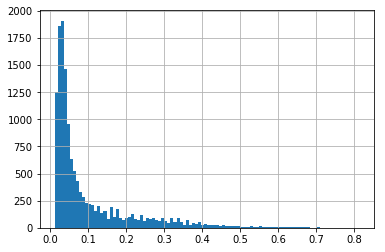

In [27]:
prep_deals.loc[(prep_deals.BookSide == 'BUY') & (prep_deals.Month == 9), 'is_accept_buy_reject'].hist(bins=100)

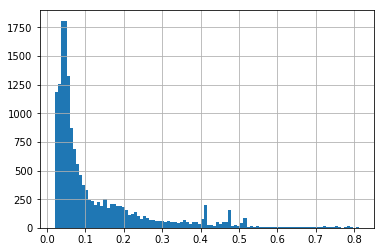

In [28]:
prep_deals.loc[(prep_deals.BookSide == 'SELL') & (prep_deals.Month == 9), 'is_accept_sell_reject'].hist(bins=100)

In [29]:
prep_deals['target'] = False
prep_deals.loc[(prep_deals.BookSide == 'BUY') & (prep_deals.Month == 9), 'target'] = \
prep_deals.loc[(prep_deals.BookSide == 'BUY') & (prep_deals.Month == 9), 'is_accept_buy_reject'] > 0.35

prep_deals.loc[(prep_deals.BookSide == 'SELL') & (prep_deals.Month == 9), 'target'] = \
prep_deals.loc[(prep_deals.BookSide == 'SELL') & (prep_deals.Month == 9), 'is_accept_sell_reject'] > 0.35

In [30]:
prep_deals['Moment'].dt.strftime('%Y-%m-%d %H:%M')

0        2020-08-03 10:00
1        2020-08-03 10:00
2        2020-08-03 10:00
3        2020-08-03 10:00
4        2020-08-03 10:00
               ...       
94207    2020-11-11 14:15
94208    2020-11-11 14:15
94209    2020-11-11 14:15
94210    2020-11-11 14:16
94211    2020-11-11 14:17
Name: Moment, Length: 94212, dtype: object

In [31]:
#prep_deals.loc[ (prep_deals.Month == 9) & (prep_deals.target), :].to_pickle('./data/marketreplay/input/good_rejects.pkl')

In [32]:
dates = list(pd.to_datetime(prep_deals.loc[(prep_deals.Month == 9) & (prep_deals.target), 
                                           'Moment'].dt.date).drop_duplicates()
                                                 .sort_values()
                                                 .dt.strftime('%Y-%m-%d'))

In [43]:
# prep_deals[(prep_deals.Hour <= 10) & (prep_deals.Month == 9) &\
#           (prep_deals['Type']=='Reject') & \
#           prep_deals.target]

prep_deals[(prep_deals.Hour <= 10) & (prep_deals.Month == 9) &\
          (prep_deals['Type']=='Reject') & \
          prep_deals.target].to_pickle('./data/marketreplay/input/morning_rejects.pkl')

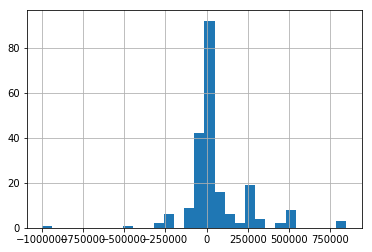

In [56]:
tmp  = pd.read_pickle('./data/marketreplay/input/morning_rejects.pkl')
tmp[tmp.BaseQty.abs() < 1_000_000].BaseQty.hist(bins = 30)

In [59]:
tmp[tmp.BaseQty.abs() <= 1_00_000].shape, tmp.shape

((159, 39), (220, 39))

In [61]:
morning_rejects = prep_deals[(prep_deals.Hour <= 10) & (prep_deals.Month == 9) &\
          (prep_deals['Type']=='Reject') & \
          prep_deals.target]
morning_rejects['RUR_QTY'] = morning_rejects['BaseQty'] * morning_rejects['ReferenceClientPrice']
morning_rejects['RUR_QTY'].abs().sum()

/Users/a16643222/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


4661022939.438887

In [16]:
# prep_deals[(prep_deals.Hour <= 10) & (prep_deals.Month == 9) &\
#           (prep_deals['Type']=='Reject')].to_pickle('./data/marketreplay/input/all_morning_rejects.pkl')

all_morning_rejects = prep_deals[(prep_deals.Hour <= 10) & (prep_deals.Month == 9) &\
          (prep_deals['Type']=='Reject')]
all_morning_rejects['RUR_QTY'] = all_morning_rejects['BaseQty'] * all_morning_rejects['ReferenceClientPrice']
all_morning_rejects['RUR_QTY'].abs().sum()

/Users/a16643222/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


40515231874.69365

In [17]:
all_morning_rejects.shape

(1764, 40)

In [46]:
l = []
for i in dates:
    v = prep_deals.loc[ 
                (prep_deals['Moment'].dt.strftime('%Y-%m-%d %H:%M') <= i+' 10:20') & \
               (prep_deals['Moment'].dt.strftime('%Y-%m-%d %H:%M') >= i+' 10:00'), 'prev_r_val' ].mean()
    print( i,  v)
    l.append(v)


2020-09-01 6.869832124928576e-09
2020-09-02 3.172736032656774e-09
2020-09-03 4.657887907795034e-09
2020-09-04 6.446745836072757e-09
2020-09-07 7.463566218880319e-09
2020-09-08 5.069578258948194e-09
2020-09-09 8.459234762265389e-09
2020-09-10 4.613399082552355e-09
2020-09-11 4.119079916294495e-09
2020-09-14 4.865260630263364e-09
2020-09-15 8.199897016580891e-09
2020-09-16 2.1798940538359157e-09
2020-09-17 1.2990383763135316e-09
2020-09-18 2.2699877682388507e-09
2020-09-21 4.035311799192039e-09
2020-09-22 3.789903833571985e-09
2020-09-23 2.734024865187908e-09
2020-09-24 5.961327122166742e-09
2020-09-25 6.139573470353467e-09
2020-09-28 7.788429745987705e-09
2020-09-29 1.3939083334766401e-08
2020-09-30 1.7792356028797217e-08


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb40ec277d0>]],
      dtype=object)

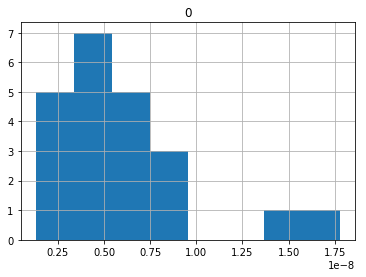

In [61]:
pd.DataFrame(l).hist(bins=8)

In [65]:
for i in dates:
    print( i, prep_deals[(prep_deals['Moment'].dt.strftime('%Y-%m-%d %H:%M') <= i+' 10:00') & \
           (prep_deals['Moment'].dt.strftime('%Y-%m-%d %H:%M') >= i+' 09:00')  ].shape )

2020-09-01 (6, 39)
2020-09-02 (3, 39)
2020-09-03 (1, 39)
2020-09-04 (7, 39)
2020-09-07 (8, 39)
2020-09-08 (0, 39)
2020-09-09 (2, 39)
2020-09-10 (4, 39)
2020-09-11 (3, 39)
2020-09-14 (5, 39)
2020-09-15 (4, 39)
2020-09-16 (2, 39)
2020-09-17 (1, 39)
2020-09-18 (2, 39)
2020-09-21 (1, 39)
2020-09-22 (7, 39)
2020-09-23 (11, 39)
2020-09-24 (3, 39)
2020-09-25 (18, 39)
2020-09-28 (3, 39)
2020-09-29 (16, 39)
2020-09-30 (8, 39)


In [26]:
#prep_deals.loc[ (prep_deals.Month == 9) & (prep_deals['Type']=='Reject')].to_pickle('./data/marketreplay/input/all_09_rejects.pkl')

In [27]:
' '.join(dates)

'2020-09-01 2020-09-02 2020-09-03 2020-09-04 2020-09-07 2020-09-08 2020-09-09 2020-09-10 2020-09-11 2020-09-14 2020-09-15 2020-09-16 2020-09-17 2020-09-18 2020-09-21 2020-09-22 2020-09-23 2020-09-24 2020-09-25 2020-09-28 2020-09-29 2020-09-30'

In [ ]:
python -u abides.py -c marketreplay_USD -t USD -d 20200914 -s 1234 -l USD_09_replay

In [ ]:
#!/bin/bash
for i in {20200901 20200902 20200903 20200904 20200907 20200908 20200909 20200910 20200911 20200914 20200915 20200916 20200917 20200918 20200921 20200922 20200923 20200924 20200925 20200928 20200929 20200930}
do
   echo "python -u abides.py -c marketreplay_USD -t USD -d $i -s 1234 -l USD_09_replay"
done